## 서울시 지역별 미세먼지 분석 및 예측(DL)

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### 데이터 분할하기

In [131]:
df = pd.read_csv('dataset/seoul_pm10.csv', encoding='cp949')
df.head()

,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.0,44.0
1,2022-12-31 23:00,강동구,68.0,55.0
2,2022-12-31 23:00,강북구,59.0,42.0
3,2022-12-31 23:00,강서구,62.0,40.0
4,2022-12-31 23:00,관악구,57.0,38.0


In [132]:
len(df['area'].unique())

26

In [133]:
df_pm10 = df.drop('pm2.5', axis=1)
df_pm25 = df.drop('pm10', axis=1)

In [134]:
df_pm10['date'] = pd.to_datetime(df_pm10['date'])
df_pm25['date'] = pd.to_datetime(df_pm25['date'])

In [135]:
print(df_pm10.dtypes)
print(df_pm25.dtypes)

date    datetime64[ns]
area            object
pm10           float64
dtype: object
date     datetime64[ns]
area             object
pm2.5           float64
dtype: object


In [136]:
# 피벗 테이블 생성
pm10_pivot = df_pm10.pivot_table(index='date', columns='area', values='pm10')
pm25_pivot = df_pm25.pivot_table(index='date', columns='area', values='pm2.5')

In [137]:
pm10_pivot.to_csv('dataset/seoul_pm10_filtered.csv')
pm25_pivot.to_csv('dataset/seoul_pm25_filtered.csv')

## 2022년 시간대별 서울시 미세먼지 농도 (PM10)

In [8]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

### 데이터 불러오기

In [4]:
# 데이터 불러오기
df = pd.read_csv('dataset/seoul_pm10_filtered.csv')
df.head()

,date,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,...,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구,평균
0,2022-01-01 00:00:00,18.0,22.0,20.0,22.0,21.0,19.0,21.0,19.0,23.0,...,11.0,21.0,21.0,22.0,22.0,19.0,20.0,20.0,21.0,20.0
1,2022-01-01 01:00:00,20.0,24.0,21.0,29.0,20.0,17.0,26.0,30.0,23.0,...,14.0,30.0,22.0,22.0,24.0,19.0,23.0,25.0,21.0,22.0
2,2022-01-01 02:00:00,18.0,24.0,20.0,25.0,18.0,18.0,23.0,25.0,25.0,...,15.0,31.0,23.0,20.0,23.0,16.0,20.0,20.0,18.0,21.0
3,2022-01-01 03:00:00,18.0,28.0,23.0,27.0,17.0,21.0,23.0,23.0,26.0,...,14.0,22.0,21.0,22.0,21.0,11.0,20.0,19.0,18.0,20.0
4,2022-01-01 04:00:00,18.0,29.0,21.0,20.0,18.0,24.0,23.0,18.0,25.0,...,13.0,20.0,19.0,18.0,19.0,14.0,19.0,20.0,18.0,20.0


### 데이터셋 확인

In [5]:
# 데이터프레임 확인
# 컬럼명 및 결측치, 데이터 타입 확인 
# 날짜 데이터 타입 변경해 줄 필요 있음
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8760 non-null   object 
 1   강남구     8685 non-null   float64
 2   강동구     8577 non-null   float64
 3   강북구     8659 non-null   float64
 4   강서구     8662 non-null   float64
 5   관악구     8582 non-null   float64
 6   광진구     8673 non-null   float64
 7   구로구     8517 non-null   float64
 8   금천구     8537 non-null   float64
 9   노원구     8637 non-null   float64
 10  도봉구     8615 non-null   float64
 11  동대문구    8121 non-null   float64
 12  동작구     8600 non-null   float64
 13  마포구     8640 non-null   float64
 14  서대문구    8528 non-null   float64
 15  서초구     8362 non-null   float64
 16  성동구     8660 non-null   float64
 17  성북구     8611 non-null   float64
 18  송파구     8570 non-null   float64
 19  양천구     8617 non-null   float64
 20  영등포구    8692 non-null   float64
 21  용산구     8625 non-null   float64
 22  

In [6]:
# 결측치 자세히 확인
df.isna().sum()

date      0
강남구      75
강동구     183
강북구     101
강서구      98
관악구     178
광진구      87
구로구     243
금천구     223
노원구     123
도봉구     145
동대문구    639
동작구     160
마포구     120
서대문구    232
서초구     398
성동구     100
성북구     149
송파구     190
양천구     143
영등포구     68
용산구     135
은평구     747
종로구     156
중구      139
중랑구      84
평균        1
dtype: int64

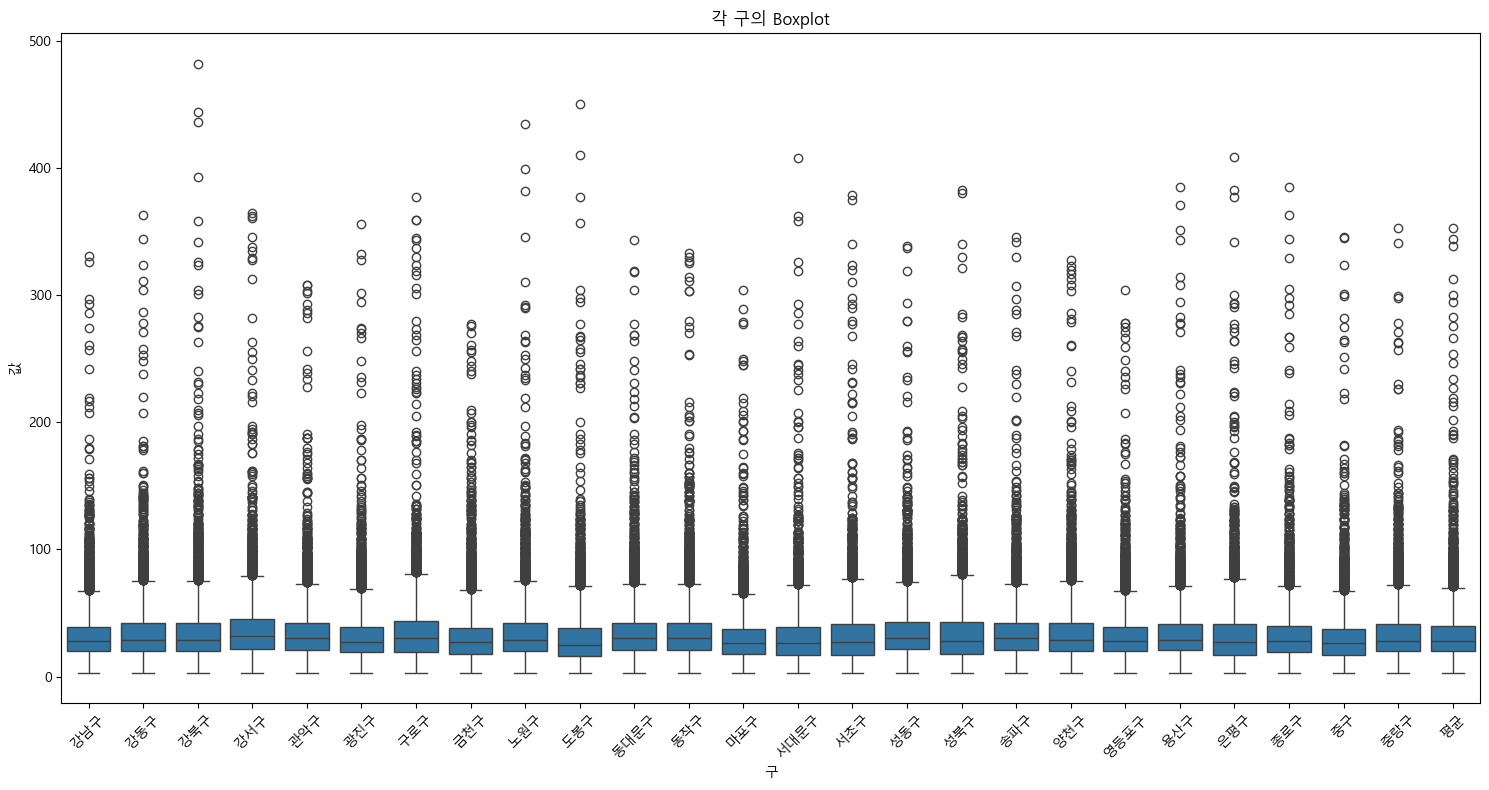

In [9]:
# 이상치 확인
df_melted = df.melt(id_vars='date', value_vars=df.columns[1:], var_name='구', value_name='값')

# boxplot 생성
plt.figure(figsize=(15, 8))
sns.boxplot(x='구', y='값', data=df_melted)
plt.xticks(rotation=45)
plt.title('각 구의 Boxplot')
plt.xlabel('구')
plt.ylabel('값')
plt.tight_layout()
plt.show()

### 데이터 전처리

In [11]:
# 데이터타입 변경 (날짜)
df['date'] = pd.to_datetime(df['date'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8760 non-null   datetime64[ns]
 1   강남구     8685 non-null   float64       
 2   강동구     8577 non-null   float64       
 3   강북구     8659 non-null   float64       
 4   강서구     8662 non-null   float64       
 5   관악구     8582 non-null   float64       
 6   광진구     8673 non-null   float64       
 7   구로구     8517 non-null   float64       
 8   금천구     8537 non-null   float64       
 9   노원구     8637 non-null   float64       
 10  도봉구     8615 non-null   float64       
 11  동대문구    8121 non-null   float64       
 12  동작구     8600 non-null   float64       
 13  마포구     8640 non-null   float64       
 14  서대문구    8528 non-null   float64       
 15  서초구     8362 non-null   float64       
 16  성동구     8660 non-null   float64       
 17  성북구     8611 non-null   float64       
 18  송파구     

In [20]:
# 결측치 처리 (평균값)
# 각 구의 평균값으로 결측치 대체
for col in df.columns[1:]:  # 'date' 컬럼 제외
    mean_value = df[col].mean()
    df.fillna({col: mean_value}, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    8760 non-null   datetime64[ns]
 1   강남구     8760 non-null   float64       
 2   강동구     8760 non-null   float64       
 3   강북구     8760 non-null   float64       
 4   강서구     8760 non-null   float64       
 5   관악구     8760 non-null   float64       
 6   광진구     8760 non-null   float64       
 7   구로구     8760 non-null   float64       
 8   금천구     8760 non-null   float64       
 9   노원구     8760 non-null   float64       
 10  도봉구     8760 non-null   float64       
 11  동대문구    8760 non-null   float64       
 12  동작구     8760 non-null   float64       
 13  마포구     8760 non-null   float64       
 14  서대문구    8760 non-null   float64       
 15  서초구     8760 non-null   float64       
 16  성동구     8760 non-null   float64       
 17  성북구     8760 non-null   float64       
 18  송파구     

In [23]:
# 클리핑 처리 함수 정의
def clip_outliers(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  
  # 클리핑
  series = series.clip(lower=lower_bound, upper=upper_bound)
  
  return series

# 각 구의 이상치 클리핑 처리
for col in df.columns[1:]:
    df[col] = clip_outliers(df[col])

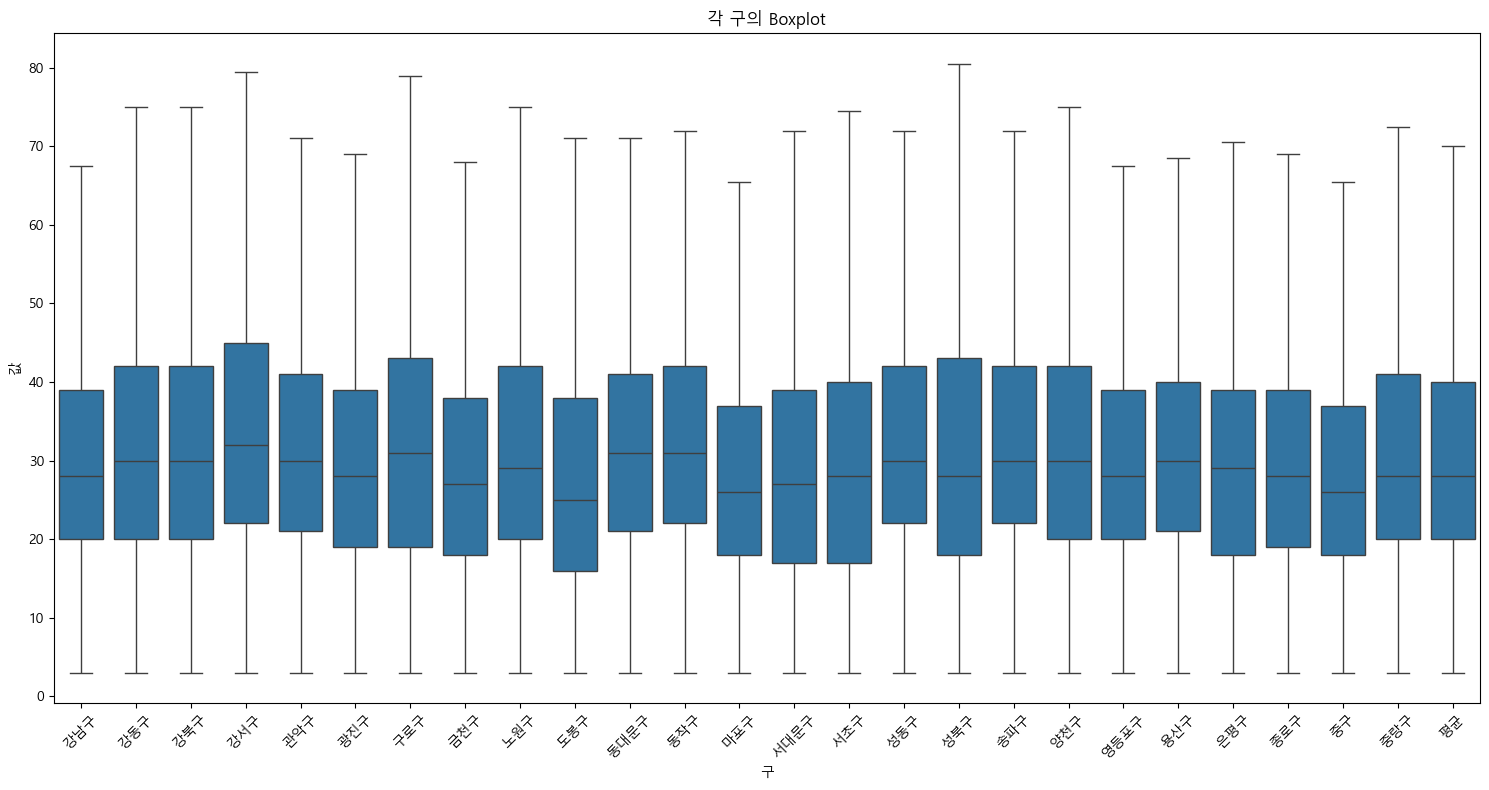

In [24]:
# 이상치 확인
df_melted = df.melt(id_vars='date', value_vars=df.columns[1:], var_name='구', value_name='값')

# boxplot 생성
plt.figure(figsize=(15, 8))
sns.boxplot(x='구', y='값', data=df_melted)
plt.xticks(rotation=45)
plt.title('각 구의 Boxplot')
plt.xlabel('구')
plt.ylabel('값')
plt.tight_layout()
plt.show()